# Decision Tree Training & Evaluation Pipeline 

This notebook automates data loading, preprocessing, model training with hyperparameter tuning, evaluation, and basic visualizations for our Heron WellNest project.

## Setup and Imports

In [9]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve, validation_curve, StratifiedKFold
from sklearn.metrics import classification_report, roc_auc_score, matthews_corrcoef, confusion_matrix, ConfusionMatrixDisplay, balanced_accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.utils import shuffle
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from collections import Counter

## Configurations


In [10]:
DATA_PATH = '../../data/classification/synthetic_dataset.csv'
# Path where the trained model will be saved
MODEL_PATH = '../../models/classification/decision-tree.joblib'

## Load Data


In [11]:
df = pd.read_csv(DATA_PATH)

target_col = 'WellbeingClass'

labels = df[target_col].unique()
feature_cols = ["p_anxiety", "p_normal", "p_depression", "p_suicidal", "p_stress", "gratitude_flag",
                "Depressed","Sad","Exhausted","Hopeless","Anxious",
                "Angry","Stressed","Restless","Calm","Relaxed",
                "Peaceful","Content","Happy","Energized","Excited",'Motivated']

print(df[target_col].value_counts())
df.head()

WellbeingClass
Struggling    3771
Thriving      2728
InCrisis      2598
Excelling      903
Name: count, dtype: int64


,p_anxiety,p_normal,p_depression,p_suicidal,p_stress,gratitude_flag,WellbeingClass,Depressed,Sad,Exhausted,...,Peaceful,Content,Happy,Energized,Excited,Motivated,flipfeel_incrisis_pct,flipfeel_struggling_pct,flipfeel_thriving_pct,flipfeel_excelling_pct
0,0.140475,0.181060,0.330063,0.135326,0.213077,0,Struggling,0,0,0,...,0,0,0,0,0,0,0.0,0.0,0.0,0.0
1,0.000000,0.000000,0.000000,0.000000,0.000000,1,Excelling,0,0,0,...,0,0,1,0,0,1,0.4,0.0,0.0,0.6
2,0.000000,0.000000,0.000000,0.000000,0.000000,0,Thriving,0,0,0,...,0,0,0,0,0,0,0.0,0.0,0.0,0.0
3,0.000000,0.000000,0.000000,0.000000,0.000000,0,Struggling,0,0,0,...,0,0,0,0,0,0,0.0,1.0,0.0,0.0
4,0.009923,0.071636,0.357258,0.424961,0.136221,0,InCrisis,0,1,0,...,0,0,0,0,0,0,1.0,0.0,0.0,0.0


## Data visualization


## Data Pre-processing


Before dropping:
p_anxiety         0
p_normal          0
p_depression      0
p_suicidal        0
p_stress          0
gratitude_flag    0
Depressed         0
Sad               0
Exhausted         0
Hopeless          0
Anxious           0
Angry             0
Stressed          0
Restless          0
Calm              0
Relaxed           0
Peaceful          0
Content           0
Happy             0
Energized         0
Excited           0
Motivated         0
dtype: int64

After dropping:
p_anxiety         0
p_normal          0
p_depression      0
p_suicidal        0
p_stress          0
gratitude_flag    0
Depressed         0
Sad               0
Exhausted         0
Hopeless          0
Anxious           0
Angry             0
Stressed          0
Restless          0
Calm              0
Relaxed           0
Peaceful          0
Content           0
Happy             0
Energized         0
Excited           0
Motivated         0
dtype: int64


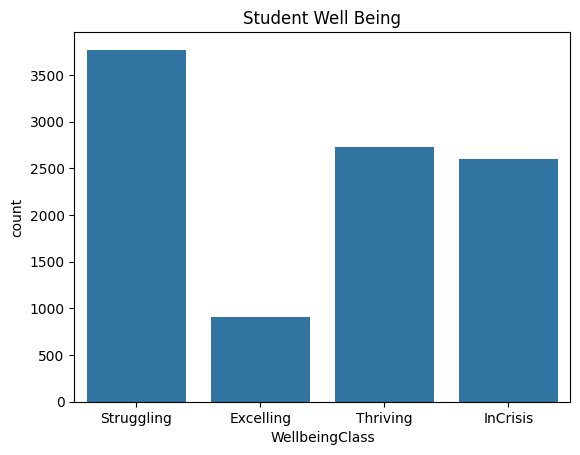

In [12]:
# Check for missing values
print("Before dropping:")
print(df[feature_cols].isna().sum())


# Drop the missing values
df = df.dropna()

# Check if missing values were dropped
print("\nAfter dropping:")
print(df[feature_cols].isna().sum())

# Class distribution
sns.countplot(x=target_col, data=df)
plt.title('Student Well Being')
plt.show()

In [13]:
# Separate features and target
X = df.drop(columns=[target_col])
y = df[target_col]

# Encode target variable
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Encode categorical features before splitting
X_encoded = pd.get_dummies(X)

# Split the data first
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y_encoded,
    test_size=0.2,
    stratify=y_encoded,
    random_state=42
)

print("Training set features dtype:\n", X_train.dtypes.unique())  # Should show only numeric types

Training set features dtype:
 [dtype('float64') dtype('int64')]


## Model training


In [14]:
dt_pipeline = Pipeline(steps=[
    ('classifier', DecisionTreeClassifier(random_state=42))
])

# Param grid
dt_param_grid = {
    'classifier__max_depth': [3, 5, 10, None],
    'classifier__min_samples_leaf': [1, 5, 10, 20],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__criterion': ['gini', 'entropy']
}

# GridSearchCV setup
grid_search_dt = GridSearchCV(
    dt_pipeline,
    dt_param_grid,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='f1_weighted',
    n_jobs=-1
)

# Fit on original (imbalanced) training data
grid_search_dt.fit(X_train, y_train)

# Save best model
best_model = grid_search_dt.best_estimator_
joblib.dump(best_model, MODEL_PATH)

print("✅ Best Parameters:", grid_search_dt.best_params_)

✅ Best Parameters: {'classifier__criterion': 'entropy', 'classifier__max_depth': None, 'classifier__min_samples_leaf': 5, 'classifier__min_samples_split': 2}


## Model Evaluation


✅ Cross-Validation Results Summary:



,mean_test_score,std_test_score,params
0,0.888220,0.009653,"{'classifier__criterion': 'entropy', 'classifi..."
1,0.888220,0.009653,"{'classifier__criterion': 'entropy', 'classifi..."
2,0.888220,0.009653,"{'classifier__criterion': 'entropy', 'classifi..."
3,0.887925,0.011661,"{'classifier__criterion': 'entropy', 'classifi..."
4,0.887925,0.011661,"{'classifier__criterion': 'entropy', 'classifi..."
...,...,...,...
91,0.576214,0.017894,"{'classifier__criterion': 'entropy', 'classifi..."
92,0.576214,0.017894,"{'classifier__criterion': 'entropy', 'classifi..."
93,0.576103,0.017907,"{'classifier__criterion': 'entropy', 'classifi..."
94,0.576103,0.017907,"{'classifier__criterion': 'entropy', 'classifi..."



📊 Classification Report (Test Set):



,precision,recall,f1-score,support
Excelling,0.783,0.757,0.770,181.000
InCrisis,0.935,0.915,0.925,520.000
Struggling,0.887,0.908,0.898,754.000
Thriving,0.860,0.859,0.860,545.000
accuracy,0.883,0.883,0.883,0.883
macro avg,0.866,0.860,0.863,2000.000
weighted avg,0.883,0.883,0.883,2000.000



🎯 Key Performance Metrics:



,Metric,Score
0,Accuracy,0.8830
1,Balanced Accuracy,0.8599
2,Precision (Macro),0.8664
3,Recall (Macro),0.8599
4,F1-Score (Macro),0.8630
5,ROC AUC (Macro),0.9560
6,Matthews Correlation Coefficient,0.8344



📝 Metric Explanations:
• Accuracy: Overall correctness (can be misleading with imbalanced data)
• Balanced Accuracy: Average of recall per class (better for imbalanced data)
• Precision (Macro): Average precision across all classes (unweighted)
• Recall (Macro): Average recall across all classes (unweighted)
• F1-Score (Macro): Harmonic mean of precision and recall (unweighted)
• ROC AUC: Area under ROC curve (measures class separability)
• MCC: Correlation between predictions and truth (-1 to +1, accounts for imbalance)

🔎 Confusion Matrix:



,Pred_Excelling,Pred_InCrisis,Pred_Struggling,Pred_Thriving
True_Excelling,137,3,13,28
True_InCrisis,9,476,27,8
True_Struggling,11,18,685,40
True_Thriving,18,12,47,468


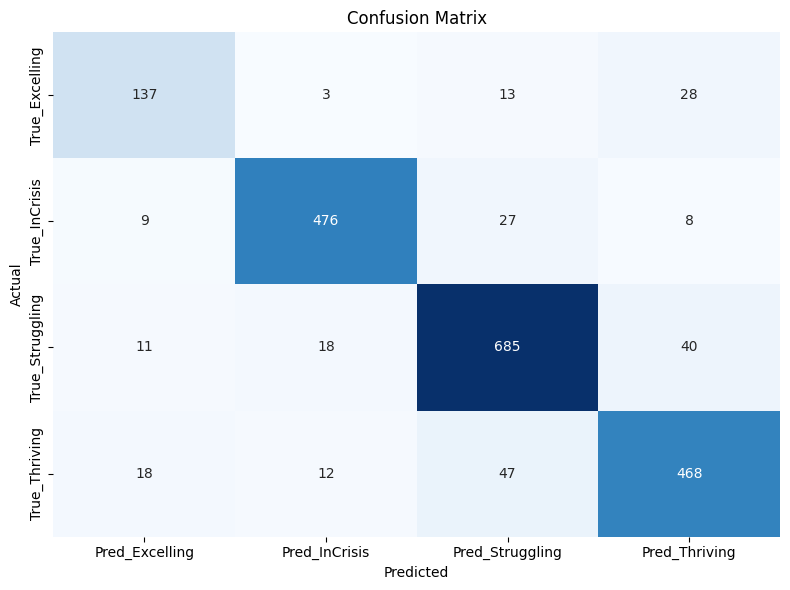

In [15]:
# --- Cross-Validation Results ---
cv_results_df = pd.DataFrame(grid_search_dt.cv_results_)
cv_summary = cv_results_df[['mean_test_score', 'std_test_score', 'params']] \
    .sort_values(by='mean_test_score', ascending=False) \
    .reset_index(drop=True)

print("\n✅ Cross-Validation Results Summary:\n")
display(cv_summary)

# --- Predictions on Test Set ---
y_pred = grid_search_dt.predict(X_test)

# Decode labels back to class names
y_test_labels = le.inverse_transform(y_test)
y_pred_labels = le.inverse_transform(y_pred)
class_names = le.classes_

# --- Classification Report ---
report_dict = classification_report(
    y_test_labels, y_pred_labels, labels=class_names,
    output_dict=True, zero_division=0
)
report_df = pd.DataFrame(report_dict).T

print("\n📊 Classification Report (Test Set):\n")
display(report_df.round(3))

# --- Key Performance Metrics ---
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_test_labels, y_pred_labels)
balanced_acc = balanced_accuracy_score(y_test_labels, y_pred_labels)
precision_macro = precision_score(y_test_labels, y_pred_labels, average='macro', zero_division=0)
recall_macro = recall_score(y_test_labels, y_pred_labels, average='macro', zero_division=0)
f1_macro = f1_score(y_test_labels, y_pred_labels, average='macro', zero_division=0)
mcc = matthews_corrcoef(y_test_labels, y_pred_labels)

# ROC AUC (multiclass)
from sklearn.preprocessing import label_binarize
y_test_binarized = label_binarize(y_test, classes=range(len(class_names)))
y_pred_proba = grid_search_dt.predict_proba(X_test)
roc_auc = roc_auc_score(y_test_binarized, y_pred_proba, average='macro', multi_class='ovr')

# Display metrics in a clean table
metrics_df = pd.DataFrame({
    'Metric': [
        'Accuracy',
        'Balanced Accuracy', 
        'Precision (Macro)',
        'Recall (Macro)',
        'F1-Score (Macro)',
        'ROC AUC (Macro)',
        'Matthews Correlation Coefficient'
    ],
    'Score': [
        accuracy,
        balanced_acc,
        precision_macro,
        recall_macro,
        f1_macro,
        roc_auc,
        mcc
    ]
})

print("\n🎯 Key Performance Metrics:\n")
display(metrics_df.round(4))

print("\n📝 Metric Explanations:")
print("• Accuracy: Overall correctness (can be misleading with imbalanced data)")
print("• Balanced Accuracy: Average of recall per class (better for imbalanced data)")
print("• Precision (Macro): Average precision across all classes (unweighted)")
print("• Recall (Macro): Average recall across all classes (unweighted)")
print("• F1-Score (Macro): Harmonic mean of precision and recall (unweighted)")
print("• ROC AUC: Area under ROC curve (measures class separability)")
print("• MCC: Correlation between predictions and truth (-1 to +1, accounts for imbalance)")

# --- Confusion Matrix ---
cm = confusion_matrix(y_test_labels, y_pred_labels, labels=class_names)

cm_df = pd.DataFrame(
    cm, index=[f"True_{cls}" for cls in class_names],
    columns=[f"Pred_{cls}" for cls in class_names]
)

print("\n🔎 Confusion Matrix:\n")
display(cm_df)

plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


---
## **Make Predictions with Custom Input**

In [18]:
# Load the saved model
loaded_model = joblib.load(MODEL_PATH)

# Define a function to make predictions
def predict_wellbeing(input_data):
    """
    Predict wellbeing class from input features.
    
    Parameters:
    -----------
    input_data : dict
        Dictionary containing all feature values
        
    Returns:
    --------
    prediction : str
        Predicted wellbeing class
    probabilities : dict
        Probability for each class
    """
    # Create DataFrame from input
    input_df = pd.DataFrame([input_data])
    
    # Ensure all columns from training are present
    # Add missing columns with 0 values
    for col in X_encoded.columns:
        if col not in input_df.columns:
            input_df[col] = 0
    
    # Reorder columns to match training data
    input_df = input_df[X_encoded.columns]
    
    # Make prediction
    prediction_encoded = loaded_model.predict(input_df)[0]
    prediction = le.inverse_transform([prediction_encoded])[0]
    
    # Get probabilities
    proba = loaded_model.predict_proba(input_df)[0]
    probabilities = {class_name: prob for class_name, prob in zip(class_names, proba)}
    
    return prediction, probabilities

# Example: Create sample input
sample_input = {
    "p_anxiety": 0.3,
    "p_normal": 0.4,
    "p_depression": 0.1,
    "p_suicidal": 0.05,
    "p_stress": 0.15,
    "gratitude_flag": 1,
    "Depressed": 0,
    "Sad": 0,
    "Exhausted": 0,
    "Hopeless": 0,
    "Anxious": 0,
    "Angry": 0,
    "Stressed": 0,
    "Restless": 0,
    "Calm": 1,
    "Relaxed": 1,
    "Peaceful": 0,
    "Content": 1,
    "Happy": 0,
    "Energized": 0,
    "Excited": 0,
    "Motivated": 0,
    "flipfeel_incrisis_pct": 0,
    "flipfeel_struggling_pct": 0,
    "flipfeel_thriving_pct": 0.4,
    "flipfeel_excelling_pct": 0.6 
}

# Make prediction
predicted_class, class_probabilities = predict_wellbeing(sample_input)

print("🔮 Prediction for Sample Input:")
print(f"\n✅ Predicted Class: {predicted_class}")
print("\n📊 Class Probabilities:")
for cls, prob in sorted(class_probabilities.items(), key=lambda x: x[1], reverse=True):
    print(f"   {cls}: {prob:.4f} ({prob*100:.2f}%)")


🔮 Prediction for Sample Input:

✅ Predicted Class: Thriving

📊 Class Probabilities:
   Thriving: 1.0000 (100.00%)
   Excelling: 0.0000 (0.00%)
   InCrisis: 0.0000 (0.00%)
   Struggling: 0.0000 (0.00%)


### **Interactive Prediction - Enter Your Own Values**

In [19]:
# ========================================
# CUSTOMIZE YOUR INPUT HERE
# ========================================
# Change the values below to make your own prediction
# Values should typically be between 0 and 1

your_input = {
    # Probability scores from NLP model (should sum to ~1.0)
    "p_anxiety": 0.2,      # Probability of anxiety detected
    "p_normal": 0.5,       # Probability of normal state
    "p_depression": 0.1,   # Probability of depression detected
    "p_suicidal": 0.05,    # Probability of suicidal thoughts detected
    "p_stress": 0.15,      # Probability of stress detected
    
    # Gratitude flag (0 or 1)
    "gratitude_flag": 1,   # 1 = gratitude expressed, 0 = not expressed
    
    # Negative emotion indicators (0-1 scale)
    "Depressed": 0,
    "Sad": 0,
    "Exhausted": 0,
    "Hopeless": 1,
    "Anxious": 0,
    "Angry": 1,
    "Stressed": 0,
    "Restless": 1,
    
    # Positive emotion indicators (0-1 scale)
    "Calm": 0,
    "Relaxed": 0,
    "Peaceful": 0,
    "Content": 0,
    "Happy": 0,
    "Energized": 0,
    "Excited": 0,
    "Motivated": 0,

    "flipfeel_incrisis_pct": 0.5,
    "flipfeel_struggling_pct": 0.5,
    "flipfeel_thriving_pct": 0.0,
    "flipfeel_excelling_pct": 0.0 
}

# Make prediction with your custom input
your_predicted_class, your_class_probabilities = predict_wellbeing(your_input)

print("🔮 YOUR PREDICTION:")
print("=" * 50)
print(f"\n✅ Predicted Wellbeing Class: {your_predicted_class}")
print("\n📊 Confidence Levels for Each Class:")
print("-" * 50)
for cls, prob in sorted(your_class_probabilities.items(), key=lambda x: x[1], reverse=True):
    bar = "█" * int(prob * 30)
    print(f"   {cls:20s} {prob:.4f} ({prob*100:5.2f}%) {bar}")

print("\n" + "=" * 50)


🔮 YOUR PREDICTION:

✅ Predicted Wellbeing Class: InCrisis

📊 Confidence Levels for Each Class:
--------------------------------------------------
   InCrisis             1.0000 (100.00%) ██████████████████████████████
   Excelling            0.0000 ( 0.00%) 
   Struggling           0.0000 ( 0.00%) 
   Thriving             0.0000 ( 0.00%) 

